In [8]:
%matplotlib inline
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import tqdm as tqdm
import string
from nltk.corpus import stopwords
stop = stopwords.words("english")
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil

from sklearn.svm import LinearSVC

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import seaborn as sns

Using TensorFlow backend.


In [9]:
data = pd.read_csv('twt_#ifc.csv')


In [10]:
data.columns


Index(['full_text', 'retweet_count', 'user_followers_count', 'favorite_count',
       'created_at', 'pos_score', 'neg_score', 'sent_score'],
      dtype='object')

In [11]:
data=data.drop(['retweet_count', 'user_followers_count', 'favorite_count',
       'created_at'],axis=1)


Overall Score



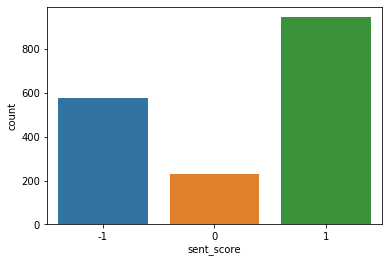

In [12]:
sns.countplot(data['sent_score'])


Data Pre Processing



In [13]:
def cleaning( review, remove_stopwords=True):
   
    

    review_text = re.sub("[^a-zA-Z]"," ", review)
   
    words = review_text.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    b=[]
    stemmer = english_stemmer 
    for word in words:
        b.append(stemmer.stem(word))

    
    return(b)


Cleaning



In [19]:
clean_Text = []
for review in data['full_text']:
    clean_Text.append( " ".join(cleaning(review)))


Top Word Count In Text(Review)



In [26]:
Top_Words_Review =pd.Series(' '.join(clean_Text).lower().split()).value_counts()[:10]
print ("Top Count Words Used In Review --", Top_Words_Review)


Top Count Words Used In Review -- covid                939
lockdown             686
indiafightscorona    341
amp                  188
india                187
case                 182
coronaviru           130
new                  124
peopl                113
state                103
dtype: int64


Tf-idf



In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=4, max_features = 10000)
vz = vectorizer.fit_transform(clean_Text)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print("social: " + str(tfidf["social"]))
print("like: " + str(tfidf["like"]))
print("covid: " + str(tfidf["covid"]))
print("inspir: " + str(tfidf["inspir"]))
print("death: " + str(tfidf["death"]))

social: 4.941010542301399
like: 4.40692805637114
covid: 1.7617319720575568
inspir: 6.521460917862246
death: 4.324236340526027


Sentiment Analysis



In [43]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
Senti = SentimentIntensityAnalyzer()
sample_review = clean_Text[:5]
for sentence in sample_review:
    sentence
    ss = Senti.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
    print( sentence) 
    print('\n')

compound: 0.6124, 
neg: 0.0, 
neu: 0.706, 
pos: 0.294, 
whi wait get fine govern take care wear mask maintain social distanc facemask lockdow


compound: 0.4404, 
neg: 0.0, 
neu: 0.756, 
pos: 0.244, 
start monday delhi govern gave relax lockdown howev educ institut


compound: 0.3612, 
neg: 0.0, 
neu: 0.615, 
pos: 0.385, 
meme inform lockdown look like


compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
lockdown focu reviv economi howev team vijaykarnataka alreadi stimul economi


compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
hello guy video get look sonam kapoor celebr inspir look priya inturu lockdown unlock priyainturu fashion trend corona covid




k-Means

In [44]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 10
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :5]:
        print(' %s' % terms[j])
    print()

Cluster 0:
 covid
 india
 coronaviru
 pandem
 indiafightscorona

Cluster 1:
 amp
 covid
 talk
 friend
 startup

Cluster 2:
 guidelin
 lockdown
 open
 june
 mall

Cluster 3:
 test
 covid
 coronaviru
 posit
 app

Cluster 4:
 case
 covid
 total
 new
 activ

Cluster 5:
 indiafightscorona
 passeng
 covid
 train
 hand

Cluster 6:
 lockdown
 state
 govern
 happen
 noth

Cluster 7:
 peopl
 amp
 covid
 age
 distribut

Cluster 8:
 corona
 one
 lockdown
 like
 plea

Cluster 9:
 lockdown
 unlock
 june
 till
 extend



LSTM 

In [51]:
Text = data.full_text
Ratings = data.sent_score
vectorizer = TfidfVectorizer(max_df=.8)
vectorizer.fit(Text)
def categorize(ratings):
    cats = []
    for rating in ratings:
        v = [0,0,0,0,0]
        v[rating-1] = 1
        cats.append(v)
    return np.array(cats)

X = vectorizer.transform(Text).toarray()
y = categorize(Ratings.values)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)

model = Sequential()
model.add(Dense(256,input_dim=X_train.shape[1]))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.fit(X_train,y_train,nb_epoch=10,batch_size=32,verbose=1)
model.evaluate(X_test,y_test)[0]

C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
1574/1574 [==============================] - 1s 917us/step - loss: 1.1531 - accuracy: 0.5394
Epoch 2/10
1574/1574 [==============================] - 1s 667us/step - loss: 0.7748 - accuracy: 0.6728
Epoch 3/10
1574/1574 [==============================] - 1s 676us/step - loss: 0.5660 - accuracy: 0.8126
Epoch 4/10
1574/1574 [==============================] - 1s 675us/step - loss: 0.3988 - accuracy: 0.8964
Epoch 5/10
1574/1574 [==============================] - 1s 664us/step - loss: 0.2746 - accuracy: 0.9352
Epoch 6/10
1574/1574 [==============================] - 1s 669us/step - loss: 0.1893 - accuracy: 0.9581
Epoch 7/10
1574/1574 [==============================] - 1s 652us/step - loss: 0.1321 - accuracy: 0.9727
Epoch 8/10
1574/1574 [==============================] - 1s 657us/step - loss: 0.0938 - accuracy: 0.9803
Epoch 9/10
1574/1574 [==============================] - 1s 638us/step - loss: 0.0670 - accuracy: 0.98670s - loss: 0.0690 - accu
Epoch 10/10
175/175 [===================

0.8941591249193463